![](../../images/featuretools.png)

# Predicting Retail Spending with Automated Feature Engineering in Featuretools

In this notebook, we will implement an automated feature engineering solution with [Featuretools](https://docs.featuretools.com/#minute-quick-start) for a set of online retail purchases. The dataset (available from the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/online+retail#)) is a series of time-stamped purchases and does not come with any labels, so we'll have to make our own prediction problem. After defining the problem, we can use automated feature engineering to build a set of features that are used for training a predictive model.

This set of retail spending data is great practice both for defining our own prediction problem (known as [prediction engineering](http://ieeexplore.ieee.org/document/7796929/)), and for using some of the time-based capabilities of Featuretools, notably cutoff times. Whenever we have time-series data, we need to be extra careful to not "leak labels" or use information from the future to predict a past event. Usually, when we're doing manual feature engineering, this can be an issue and often, a system will work well in development but utterly fail when deployed because it was trained on invalid data. Fortunately, Featuretools will take care of the time issue for us, creating a rich set of features that obey the time restrictions.

## Roadmap 

Following is an outline for this notebook:

1. Read in data, inspect, and clean
2. Develop a prediction problem
    * Create a dataframe of labels - what we want to predict, and cutoff times - the point that all data must come before for predicting a label
3. Create an entityset and add entities
    * Normalize the original table to develop new tables 
    * These new tables can be used for making features
4. Run deep feature sythesis on the entityset to make features
    * Use the cutoff times to make features using valid data for each label
5. Use the features to train a machine learning model
    * Measure performance of the model relative to an informed baseline
6. Tune deep feature synthesis 
    * Specify custom primitives
    * Adjust maximum depth of features
    * Re-evaluate model

This problem is a great display of both the time and feature-creation capabilities of Featuretools. Also, we'll be able to use custom primitives to expand on our domain knowledge. Doing this problem by hand and ensuring we use only valid data for each label is a daunting task (as can be seen in the Manual Retail Spending notebook)! 

In [1]:
# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Load in Raw Data

The raw data is a collection of purchases from an online retailer collected in 2010-2011. Each row in the original data represents one product that was purchased with multiple purchases forming an order. There are a few issues with the data that will need to be addressed (as with most real-world datasets)!

This code loads in the data, converts the price in Pounds to dollars (based on the exchange rate on May 31, 2011), subsets the data to 2011, and creates a column representing the total of the purchase. The original data description can be found on [the UCI Machine Learning Repository.](https://archive.ics.uci.edu/ml/datasets/online+retail#)

In [2]:
data = pd.read_excel("Online Retail.xlsx")

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
data.shape

(541909, 8)

In [5]:
# Convert to dollars
data['UnitPrice'] = data['UnitPrice'] * 1.65
data['total'] = data['UnitPrice'] * data['Quantity']


In [6]:
# Restrict data to 2011
data_2011 = data[data['InvoiceDate'].dt.year == 2011]

In [7]:
data_2011.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,3.2175,13313.0,United Kingdom,32.175
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,3.4650,13313.0,United Kingdom,17.325
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,2.0625,13313.0,United Kingdom,20.625


In [8]:
data_2011.shape

(499428, 9)

In [9]:
data_2011.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499428 entries, 42481 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    499428 non-null  object        
 1   StockCode    499428 non-null  object        
 2   Description  498099 non-null  object        
 3   Quantity     499428 non-null  int64         
 4   InvoiceDate  499428 non-null  datetime64[ns]
 5   UnitPrice    499428 non-null  float64       
 6   CustomerID   379979 non-null  float64       
 7   Country      499428 non-null  object        
 8   total        499428 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 38.1+ MB


## Data Cleaning

There are a few issues we need to address with the data. First, we'll drop the duplicated rows, then we'll drop any rows that contain a `nan`. Finally, we can add a `Boolean` column indicating whether or not an order is a cancellation.

In [10]:
data_2011.duplicated().sum()

4768

- There are 4768 duplicate values which we will drop as they will add bias in the dataset

In [11]:
data_2011.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1329
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     119449
Country             0
total               0
dtype: int64

- There are about 119449 missing values in the customerID and it is very difficult to fill in such column also as they are unique ID belonging to each customer. There we will be dropping those too. 

In [12]:
# drop the duplicates
data_2011 = data_2011.drop_duplicates()

# drop rows with null customer id
data_2011 = data_2011.dropna(axis=0)

data_2011['cancelled'] = data_2011['InvoiceNo'].str.startswith('C', na = False)

In [13]:
# Size has changed as we have removed duplicats
data_2011.shape

(375250, 10)

In [14]:
data_2011[data_2011.cancelled==True].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total,cancelled
42557,C540006,21306,SET/4 DAISY MIRROR MAGNETS,-1,2011-01-04 10:48:00,3.4650,14606.0,United Kingdom,-3.4650,True
42558,C540006,84352,SILVER CHRISTMAS TREE BAUBLE STAND,-1,2011-01-04 10:48:00,27.9675,14606.0,United Kingdom,-27.9675,True
42559,C540006,22423,REGENCY CAKESTAND 3 TIER,-1,2011-01-04 10:48:00,21.0375,14606.0,United Kingdom,-21.0375,True
42560,C540007,21055,TOOL BOX SOFT TOY,-6,2011-01-04 11:08:00,14.7675,15379.0,United Kingdom,-88.6050,True
42561,C540007,22274,FELTCRAFT DOLL EMILY,-6,2011-01-04 11:08:00,4.8675,15379.0,United Kingdom,-29.2050,True


- All of the cancelled orders have negative quantities which mean that they cancel out with the corresponding purchase. We'll leave in the cancelled purchases, because if our goal (defined later in the prediction problem) is to predict the total amount purchased by a customer, we'll need to take into account their cancelled orders.

In [15]:
data_2011['cancelled'].value_counts(normalize =True)

False    0.978172
True     0.021828
Name: cancelled, dtype: float64

- There are about 2% invoice that were cancelled. 

In [16]:
#summary statitics for the new data
data_2011.describe()

,Quantity,UnitPrice,CustomerID,total
count,375250.000000,375250.000000,375250.000000,375250.000000
mean,12.252296,5.762031,15265.136168,33.972397
std,258.180877,119.054102,1710.927381,733.803756
min,-80995.000000,0.000000,12346.000000,-277974.840000
25%,2.000000,2.062500,13901.000000,7.012500
50%,5.000000,3.217500,15108.000000,19.305000
75%,12.000000,6.187500,16767.000000,32.670000
max,80995.000000,64300.500000,18287.000000,277974.840000


- We can see that most total purchase prices are less than 50 (this is for a one item). 
- The negative numbers represent cancelled orders. We can plot the purchase total by country (limited to only positive amounts and less than \$1000) to see if there are differences between countries.

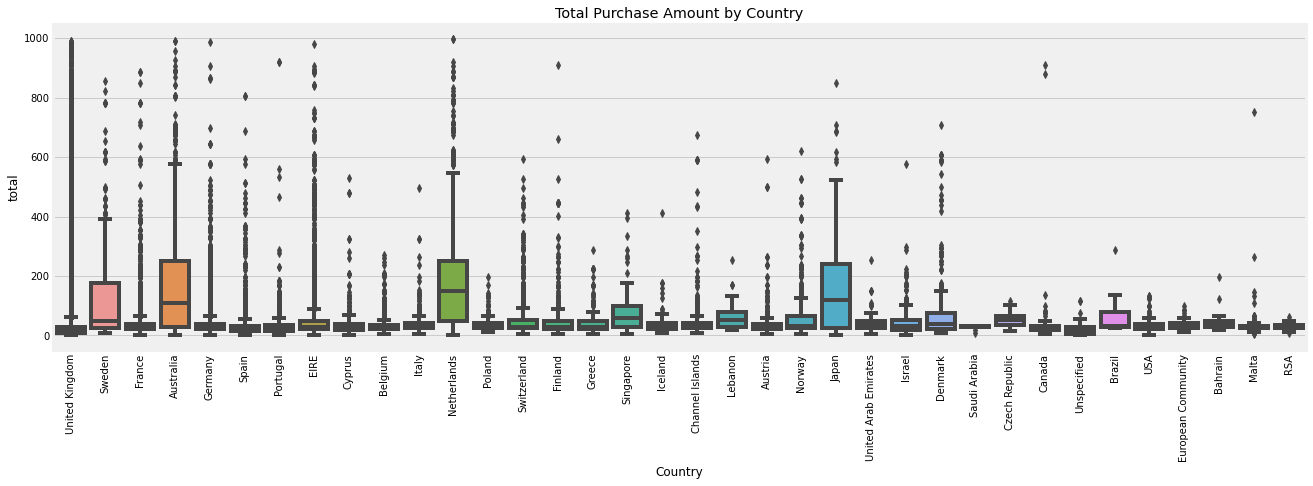

In [17]:
plt.figure(figsize = (20, 6))
sns.boxplot(x = 'Country', y = 'total', data = data_2011[(data_2011['total'] > 0) & (data_2011['total'] < 1000)]);
plt.title("Total Purchase Amount by Country");
plt.xticks(rotation = 90);

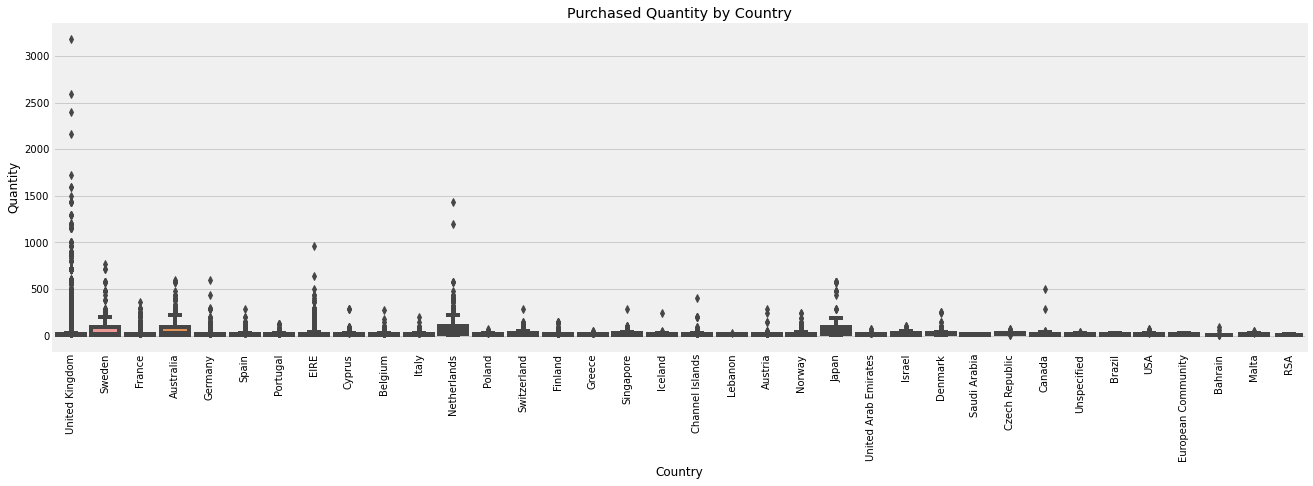

In [18]:
plt.figure(figsize = (20, 6))
sns.boxplot(x = 'Country', y = 'Quantity', data = data_2011[(data_2011['total'] > 0) & (data_2011['total'] < 1000)]);
plt.title("Purchased Quantity by Country");
plt.xticks(rotation = 90);

- Both the purchase total and the quantity are heavily skewed. This occurs often in real-world data and means this might be difficult as a regression problem (predict the actual spending amount). 
- We might want to frame the problem as classification because the large purchase totals could throw off a machine learning algorithm. Our other option would be to remove the outliers, but given that these are probably legitimate, that does not seem like a responsible choice!

### Skewness of Data

To see the extent of how skewed the data is, we can use an [Empirical Cumulative Distribution Function (ECDF) plot](https://www.itl.nist.gov/div898/software/dataplot/refman1/auxillar/ecdfplot.htm). 

In [19]:
def ecdf(data_2011):
    x = np.sort(data_2011)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

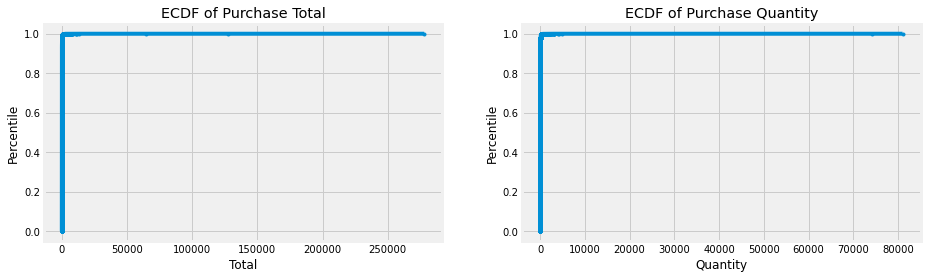

In [20]:
plt.figure(figsize = (14, 4))

# Total
plt.subplot(121)
x, y = ecdf(data_2011.loc[data_2011['total'] > 0, 'total'])
plt.plot(x, y, marker = '.')
plt.xlabel('Total'); plt.ylabel('Percentile'); plt.title('ECDF of Purchase Total');

# Quantity
plt.subplot(122)
x, y = ecdf(data_2011.loc[data_2011['total'] > 0, 'Quantity'])
plt.plot(x, y, marker = '.')
plt.xlabel('Quantity'); plt.ylabel('Percentile'); plt.title('ECDF of Purchase Quantity');

- The majority of total purchases are less than \$20, but there a number of outliers.
- Rather than using a regression problem, we therefore might want to try classifying customers based on their spending per month.

# Prediction Problem

- The goal of machine learning is to predict some quantity (regression) or a label (classification). 
- **Our data exploration showed that regression might not be the best approach because of the extreme outliers, so instead we can make the problem classification.**

- With this dataset, there are an _unlimited number of prediction problems_ because there are no labels (unlike in many machine learning competitions).
- Choosing a worthwhile quantity to predict therefore becomes critical. In most real-world situations, we could use a domain expert to frame a problem based on what they know is important in the field, and then it's our objective to make a set of labels and features based on that problem. This is known as prediction engineering.

- **We'll frame the problem as predicting whether or not a customer will spend more than 500 dollars in the next month.**
- This could be useful to a business because it will let them market more effectively to those customers who are likely to spend more. Moreover, an online retailer could advertise differently to customers based on their predicted class of spending. 

- **Instead of picking just a single month for predictions, we can use each customer as a label multiple times. In other words, we not only predict whether a given customer will spend more than 500 dollars in May, but we also ask the same question in June, July, and so on.**

The thing to note is that for each month, we _can't use data from the future_ to predict the class of spending. Each month we can use information from _any previous month_ which means that our predictions should get more accurate as we advance further in time through the data since we'll be able to use more information. Each label for a customer therefore has a different set of features because there is more or less data available to us depending on the month. Doing this by hand is very tedious and error-prone, but we'll see how Featuretools is able to handle the times associated with each label using cutoff times.




## Making Labels

The function below takes in a start date and an end date (which we set to 30 days apart) and generates a dataframe of the labels, which depends on how much the customer spent in the period and the threshold. Our threshold will be \$500 for this prediction problem.

For customers who appear in the data prior to the start date but then do have a purchase in between the start and end date, we set their total to 0. If we simply did not include them in the labels, then that would be cheating since we have no way of knowing ahead of time that they will not spend anything in the next month.

In [21]:
data_2011.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'total', 'cancelled'],
      dtype='object')

In [22]:
def make_retail_cutoffs_total(start_date, end_date, threshold = 500):
    
    # Find customers who exist before start date
    customer_pool = data_2011[data_2011['InvoiceDate'] < start_date]['CustomerID'].unique()
    tmp = pd.DataFrame({'CustomerID': customer_pool})

    # For customers in the customer pool, find their sum between the start and end date
    totals = data_2011[data_2011['CustomerID'].isin(customer_pool) & 
        (data_2011['InvoiceDate'] > start_date) & 
        (data_2011['InvoiceDate']<end_date)
    ].groupby('CustomerID')['total'].sum().reset_index()
    
    # Merge with all the customer ids to record all customers who existed before start date
    totals = totals.merge(tmp, on = 'CustomerID', how = 'right')

    # Set the total for any customer who did not have a purchase in the timeframe equal to 0
    totals['total'] = totals['total'].fillna(0)
    
    # Label is based on the threshold
    totals['label'] = (totals['total'] > threshold).astype(int)
        
    # The cutoff time is the start date
    totals['cutoff_time'] = pd.to_datetime(start_date)
    totals = totals[['CustomerID', 'cutoff_time', 'total', 'label']]
    
    return totals

In [23]:
may_spending = make_retail_cutoffs_total(pd.datetime(2011, 5, 1), pd.datetime(2011, 6, 1))
may_spending.head()

,CustomerID,cutoff_time,total,label
0,13313.0,2011-05-01,499.026,0
1,18097.0,2011-05-01,1318.977,1
2,16656.0,2011-05-01,1804.176,1
3,16875.0,2011-05-01,0.000,0
4,13094.0,2011-05-01,678.942,1


- For each customer who appeared in the data before May, we have a label for them for the month of May which is the sum of their spending in May converted to a binary label. When we make features for these labels, we can only use data from _before May_.
- The `cutoff_time` represents the point at which any data we use must come before and the `label` is based on our threshold of \$500. 

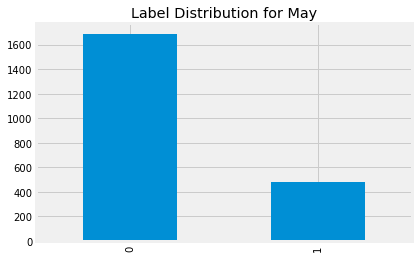

In [24]:
may_spending['label'].value_counts().plot.bar();
plt.title('Label Distribution for May');

In [25]:
may_spending['label'].value_counts()

0    1689
1     483
Name: label, dtype: int64

- **This is an imbalanced classification problem which means that we probably don't want to use accuracy as our metric.**

### Metrics

Instead of accuracy, we can measure performance in terms of:

1. **Precision**: the percentage of customers predicted to spend more than \$500 that actually did
2. **Recall** : the percentage of customers that actually spent more than \$500 that were correctly identified
3. **F1 score**: the harmonic mean of precision and recall
4. **Receiver Operating characteristic Area Under the Curve (ROC AUC)**: a 0 to 1 measure (with 1 being optimal) that measures the performance of a model across a range of thresholds

We'll have to establish a baseline for these metrics (which will be a little later) so we know whether machine learning is useful for this task.

Next we'll go ahead and make labels for the rest of the year. Keep in mind that this will generate one label for each customer for each month. We're used to thinking of a single label per customer, but since we have the data, we might as well use each customer as a training example as many times as possible (as long as we use valid data each time). A greater number of training observations should increase the predictive power of our model.

In [26]:
#making labels for each month
march_spending = make_retail_cutoffs_total('2011-03-01', '2011-04-01', 500)
april_spending = make_retail_cutoffs_total('2011-04-01', '2011-05-01', 500)
june_spending = make_retail_cutoffs_total('2011-06-01', '2011-07-01', 500)
july_spending = make_retail_cutoffs_total('2011-07-01', '2011-08-01', 500)
august_spending = make_retail_cutoffs_total('2011-08-01', '2011-09-01', 500)
september_spending = make_retail_cutoffs_total('2011-09-01', '2011-10-01', 500)
october_spending = make_retail_cutoffs_total('2011-10-01', '2011-11-01', 500)
november_spending = make_retail_cutoffs_total('2011-11-01', '2011-12-01', 500)
december_spending = make_retail_cutoffs_total('2011-12-01', '2012-01-01', 500)

In [27]:
labels = pd.concat([march_spending, april_spending, may_spending, june_spending, july_spending, august_spending, 
                    september_spending, october_spending, november_spending, december_spending], axis = 0)
#labels.to_csv('../input/labels.csv')
print(labels.shape)
labels.label.value_counts(normalize=True)

(28133, 4)


0    0.829453
1    0.170547
Name: label, dtype: float64

- We have roughly 28,000 labels with ~17% of them positive.
- The total is very skewed, with several customers recording negative total for some months (they had more cancellations than purchases). By framing this as a classification problem, we don't have to worry about the outlying purchase totals throwing off our model. 

Just to examine the data, we can plot the total spending distribution by month (with negative totals removed).

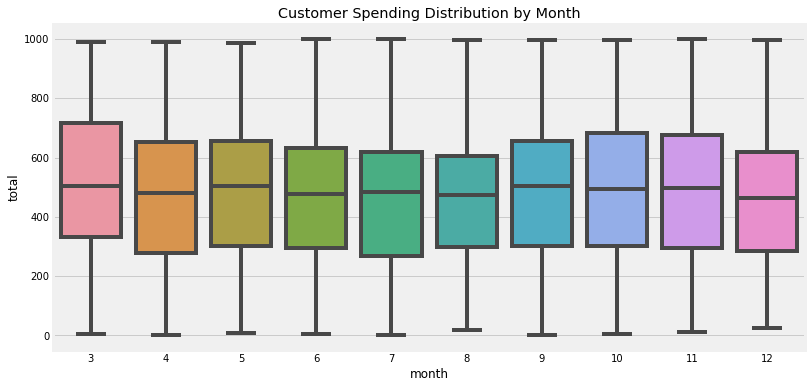

In [28]:
plot_labels = labels.copy()
plot_labels['month'] = plot_labels['cutoff_time'].dt.month

plt.figure(figsize = (12, 6))
sns.boxplot(x = 'month', y = 'total', 
            data = plot_labels[(plot_labels['total'] > 0) & (plot_labels['total'] < 1000)]);
plt.title('Customer Spending Distribution by Month');

Let's zoom in to one customer to make sure we understand the labels. 

In [29]:
labels.loc[labels['CustomerID'] == 12347]

,CustomerID,cutoff_time,total,label
666,12347.0,2011-03-01,0.0000,0
666,12347.0,2011-04-01,1049.8125,1
666,12347.0,2011-05-01,0.0000,0
666,12347.0,2011-06-01,631.1580,1
666,12347.0,2011-07-01,0.0000,0
666,12347.0,2011-08-01,965.1015,1
666,12347.0,2011-09-01,0.0000,0
666,12347.0,2011-10-01,2135.6280,1
666,12347.0,2011-11-01,0.0000,0
666,12347.0,2011-12-01,370.9530,0


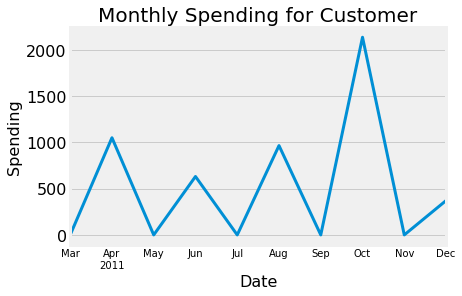

In [30]:
labels.loc[labels['CustomerID'] == 12347].set_index('cutoff_time')['total'].plot(figsize = (6, 4), linewidth = 3)
plt.xlabel('Date', size = 16); 
plt.ylabel('Spending', size = 16); 
plt.title('Monthly Spending for Customer', size = 20);
plt.xticks(size = 16); plt.yticks(size = 16);

- One customer, 10 different labels. It seems like it might be difficult to predict this customer's spending given her fluctuating total spending! We'll have to see if Featuretools is up to the task.

We now have our prediction problem all set. The next step is to start making features we can use in a machine learning model.

# Featuretools Implementation

- The first step in Featuretools is to create an `EntitySet` which will hold all of our data and the relationships between the multiple tables (which we'll create shortly). Initially we'll add the entire `data` as an `entity` to the set. Since data has a `time_index`, we'll add that and specify the variable type of the product description.

- The `time_index` represents the first time the information in that row is known. When we build features, Featuretools will use this `time_index` to filter data based on the cutoff time of the label. We can't use any purchases from after the cutoff time of the label to make features for that label.

In [31]:
data_2011.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total,cancelled
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,3.2175,13313.0,United Kingdom,32.175,False
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325,False
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325,False
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,3.4650,13313.0,United Kingdom,17.325,False
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,2.0625,13313.0,United Kingdom,20.625,False


In [32]:
es = ft.EntitySet(id="Online Retail Logs")

# Add the entire data table as an entity
es.entity_from_dataframe("purchases",
                         dataframe=data_2011,
                         index="purchases_index",
                         time_index = 'InvoiceDate',
                         variable_types = {'Description': ft.variable_types.Text})

es['purchases']

Entity: purchases
  Variables:
    purchases_index (dtype: index)
    InvoiceNo (dtype: categorical)
    StockCode (dtype: categorical)
    Quantity (dtype: numeric)
    InvoiceDate (dtype: datetime_time_index)
    UnitPrice (dtype: numeric)
    CustomerID (dtype: numeric)
    Country (dtype: categorical)
    total (dtype: numeric)
    cancelled (dtype: boolean)
    Description (dtype: text)
  Shape:
    (Rows: 375250, Columns: 11)

### Normalizing Entities

In order to create new tables out of the original table, we can normalize this `entity`. This creates new tables by creating a unique row for every variable that we pass in, such as the customer or the product.

The code below creates a new entity for the `products` where each row contains one product and the columns describe the product. 

In [33]:
# create a new "products" entity
es.normalize_entity(new_entity_id="products",
                    base_entity_id="purchases",
                    index="StockCode",
                    additional_variables=["Description"])

es['products'].df.head()

,StockCode,Description,first_purchases_time
22386,22386,JUMBO BAG PINK POLKADOT,2011-01-04 10:00:00
21499,21499,BLUE POLKADOT WRAP,2011-01-04 10:00:00
21498,21498,RED RETROSPOT WRAP,2011-01-04 10:00:00
22379,22379,RECYCLING BAG RETROSPOT,2011-01-04 10:00:00
20718,20718,RED RETROSPOT SHOPPER BAG,2011-01-04 10:00:00


- The `first_purchases_time` is automatically created because the `purchases` table has a time index. This represents the first time the product appears in the purchase data. Again, Featuretools will filter data from this table for each label so that we only build valid features. 

- We can use this table to create new features; the products table is a parent of the `purchases` table with the linking variable `product_id`. For each product in `products`, there can be multiple purchases of that product in `purchases`. 

### Additional Tables

We'll repeat the process to create tables for both the `customers` and the `orders`. `normalize_entity` automatically creates the relationships and time index so we don't have to do that ourselves. If we want to include any other additional variables in the table, we can pass those in. These variables must be unique to the object that we are normalizing for. As an example, each order comes from one country, so we can include that as additional variables when creating the `orders` table. However, the description is not unique to an order, so that should not be a variable that appears in the orders table.

In [34]:
es['purchases']

Entity: purchases
  Variables:
    purchases_index (dtype: index)
    InvoiceNo (dtype: categorical)
    StockCode (dtype: id)
    Quantity (dtype: numeric)
    InvoiceDate (dtype: datetime_time_index)
    UnitPrice (dtype: numeric)
    CustomerID (dtype: numeric)
    Country (dtype: categorical)
    total (dtype: numeric)
    cancelled (dtype: boolean)
  Shape:
    (Rows: 375250, Columns: 10)

In [35]:
# create a new "customers" entity based on the orders entity
es.normalize_entity(new_entity_id="customers",
                    base_entity_id="purchases",
                    index="CustomerID")

# create a new "orders" entity
es.normalize_entity(new_entity_id="orders",
                    base_entity_id="purchases",
                    index="InvoiceNo",
                    additional_variables=["Country", 'cancelled'])

es

Entityset: Online Retail Logs
  Entities:
    purchases [Rows: 375250, Columns: 8]
    products [Rows: 3612, Columns: 3]
    customers [Rows: 4244, Columns: 2]
    orders [Rows: 20482, Columns: 4]
  Relationships:
    purchases.StockCode -> products.StockCode
    purchases.CustomerID -> customers.CustomerID
    purchases.InvoiceNo -> orders.InvoiceNo

# Deep Feature Synthesis 

Now that our `EntitySet` is defined with the proper relationships between tables, we can perform [deep feature synthesis](http://www.jmaxkanter.com/static/papers/DSAA_DSM_2015.pdf) to generate 100s or 1000s of features. We can theoretically make features for any entity, but since our objective is to classify customer spending, we'll make features for each customer for each month. 

## Using cutoff times

To ensure the features are valid for the customer and the month, we'll pass in the labels dataframe that has the cutoff time for each customer for each month. Featuretools will make one row for each customer for each month, with the features for each month derived only from data prior to the cutoff time. This is an _extremely useful method_ because it means we don't have to worry about using invalid data to make features. For example, if we were doing this by hand, it would be very easy to create features that use information from the future to make features for the labels, which is not allowed. One issue when we have the entire dataset is that _we have access to all the data_ and must prevent ourselves from using it when building training features since _when our model is deployed, it won't have access to data from the future_ and we want our models to do well in deployment.

The requirements of the cutoff time dataframe are that the first column contains the ids corresponding to the index of the target entity, and the second column must have the cutoff times. Featuretools then takes care of the rest, for each month making features only using valid data. 

The following call will generate features for each customer, resulting in a `feature_matrix` where each row consists of one customer for one month corresponding to a label and each column is one feature. 

In [36]:
labels.head()

,CustomerID,cutoff_time,total,label
0,13313.0,2011-03-01,0.000,0
1,18097.0,2011-03-01,0.000,0
2,16656.0,2011-03-01,589.248,1
3,16875.0,2011-03-01,0.000,0
4,13094.0,2011-03-01,115.434,0


In [37]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28133 entries, 0 to 4196
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CustomerID   28133 non-null  float64       
 1   cutoff_time  28133 non-null  datetime64[ns]
 2   total        28133 non-null  float64       
 3   label        28133 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 1.1 MB


In [38]:
labels.rename(columns = {'cutoff_time':'time'}, inplace = True)

In [39]:
es

Entityset: Online Retail Logs
  Entities:
    purchases [Rows: 375250, Columns: 8]
    products [Rows: 3612, Columns: 3]
    customers [Rows: 4244, Columns: 2]
    orders [Rows: 20482, Columns: 4]
  Relationships:
    purchases.StockCode -> products.StockCode
    purchases.CustomerID -> customers.CustomerID
    purchases.InvoiceNo -> orders.InvoiceNo

In [40]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='customers',
                                       cutoff_time = labels, verbose = 2,
                                       cutoff_time_in_index = True,
                                       chunk_size = len(labels), n_jobs = -1,
                                       max_depth = 1)

feature_matrix.head()

Built 27 features
EntitySet scattered to 8 workers in 6 seconds                                   
Elapsed: 00:00 | Progress:   0%|                                                

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/pytho

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

Elapsed: 00:05 | Progress:   4%|██                                              

ore/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between inst

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

Elapsed: 00:06 | Progress:  10%|█████                                           

le to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported betw/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between 

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

Elapsed: 00:08 | Progress:  18%|████████▌                                       

da3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to so

Elapsed: 00:08 | Progress:  26%|████████████▌                                   

r' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anacon

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

Elapsed: 00:09 | Progress:  36%|█████████████████▍                              

r' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anacon

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

Elapsed: 00:09 | Progress:  46%|█████████████████████▊                          

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

Elapsed: 00:09 | Progress:  56%|██████████████████████████▉                     

r' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anacon

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

Elapsed: 00:10 | Progress:  68%|████████████████████████████████▌               

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

Elapsed: 00:11 | Progress:  81%|██████████████████████████████████████▊         

t' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anacon

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/pytho

Elapsed: 00:12 | Progress:  95%|█████████████████████████████████████████████▌  

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  warn(f"Unable to sort modes: {err}")
/Users/adunifekizitookoye/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorith

Elapsed: 00:13 | Progress: 100%|████████████████████████████████████████████████


,,COUNT(purchases),MAX(purchases.Quantity),MAX(purchases.UnitPrice),MAX(purchases.total),MEAN(purchases.Quantity),MEAN(purchases.UnitPrice),MEAN(purchases.total),MIN(purchases.Quantity),MIN(purchases.UnitPrice),MIN(purchases.total),...,STD(purchases.total),SUM(purchases.Quantity),SUM(purchases.UnitPrice),SUM(purchases.total),DAY(first_purchases_time),MONTH(first_purchases_time),WEEKDAY(first_purchases_time),YEAR(first_purchases_time),total,label
CustomerID,time,,,,,,,,,,,,,,,,,,,,,
13313.0,2011-03-01,17,25,7.0125,58.410,10.058824,3.692118,29.826176,4,0.6930,17.3250,...,11.998083,171,62.7660,507.0450,4,1,1,2011,0.000,0
18097.0,2011-03-01,9,60,16.4175,143.550,30.000000,4.882167,87.021000,6,0.6930,33.2640,...,41.359375,270,43.9395,783.1890,4,1,1,2011,0.000,0
16656.0,2011-03-01,14,216,14.0250,498.960,56.285714,5.079643,109.184036,-12,0.6930,-32.6700,...,144.361356,788,71.1150,1528.5765,4,1,1,2011,589.248,1
16875.0,2011-03-01,52,24,27.9675,65.670,7.250000,7.433250,24.218192,-8,0.4785,-16.4175,...,17.671397,377,386.5290,1259.3460,4,1,1,2011,0.000,0
13094.0,2011-03-01,3,72,1.7490,125.928,72.000000,1.749000,125.928000,72,1.7490,125.9280,...,0.000000,216,5.2470,377.7840,4,1,1,2011,115.434,0


We will want to drop the `total` and `label` columns before training because these were passed through from the `cutoff_time` data (this happens a little later). We also can remove the `MODE` of the StockCode and InvoiceNo. These should not be used for creating features since they are index variables.

In [41]:
feature_matrix = feature_matrix.drop(columns = ['MODE(purchases.StockCode)', 'MODE(purchases.InvoiceNo)'])
feature_matrix.shape

(28133, 27)

Initially we did not generate very many features because we limited the `max_depth` to 1. This means that only 1 aggregation will be stacked at a time. Let's take a look at some of the features. First, we'll zoom back in to a single one of the customers.

In [42]:
feature_matrix.loc[12347, :].sample(10, axis = 1)

,STD(purchases.total),NUM_UNIQUE(purchases.InvoiceNo),MAX(purchases.UnitPrice),MIN(purchases.Quantity),SKEW(purchases.Quantity),total,SUM(purchases.Quantity),MAX(purchases.total),STD(purchases.Quantity),MIN(purchases.UnitPrice)
time,,,,,,,,,,
2011-03-01,11.648498,1,21.0375,3,0.912823,0.0000,315,63.1125,7.510584,0.6930
2011-04-01,11.648498,1,21.0375,3,0.912823,1049.8125,315,63.1125,7.510584,0.6930
2011-05-01,54.024473,2,21.0375,3,6.687266,0.0000,798,411.8400,32.387922,0.4125
2011-06-01,54.024473,2,21.0375,3,6.687266,631.1580,798,411.8400,32.387922,0.4125
2011-07-01,47.323962,3,21.0375,2,7.504132,0.0000,994,411.8400,28.279725,0.4125
2011-08-01,47.323962,3,21.0375,2,7.504132,965.1015,994,411.8400,28.279725,0.4125
2011-09-01,46.147217,4,21.0375,2,8.177428,0.0000,1271,411.8400,25.078283,0.4125
2011-10-01,46.147217,4,21.0375,2,8.177428,2135.6280,1271,411.8400,25.078283,0.4125
2011-11-01,42.293503,5,21.0375,2,9.083077,0.0000,1947,411.8400,21.064101,0.4125


- We see that as we get deeper into the year, the numbers change for this customer because we are using more information to build the features. We would expect our predictions to get more accurate with time because we are incorporating more information. 
- However, it's also possible that customer behavior changes over time and therefore using all the previous data might not actually be useful.

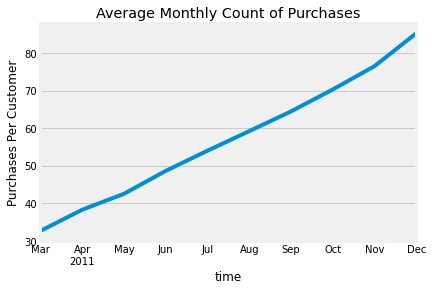

In [43]:
# feature_matrix.reset_index(inplace = True)

feature_matrix.groupby('time')['COUNT(purchases)'].mean().plot();
plt.title('Average Monthly Count of Purchases');
plt.ylabel('Purchases Per Customer');

This shows that as we progress through time, we have more purchases per customer to use for prediction.

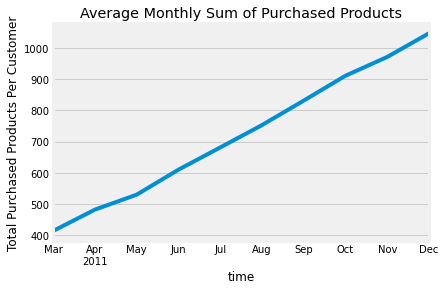

In [44]:
feature_matrix.groupby('time')['SUM(purchases.Quantity)'].mean().plot();
plt.title('Average Monthly Sum of Purchased Products');
plt.ylabel('Total Purchased Products Per Customer');

Naturally, as we include more information, our forecasts should improve in accuracy. Therefore, if we are predicting purchase in November, we would expect better performance than predicting purchases in June.

## Correlations

As a first approximation of useful features, we can see if there are any significant correlations between the features and the `total`. We'll one-hot encode the categorical features first.

In [45]:
feature_matrix = pd.get_dummies(feature_matrix).reset_index()
feature_matrix.shape

(28133, 29)

In [46]:
corrs = feature_matrix.corr().sort_values('total')
corrs['total'].head()

MONTH(first_purchases_time)     -0.083372
DAY(first_purchases_time)       -0.050790
MIN(purchases.total)            -0.026663
WEEKDAY(first_purchases_time)   -0.009223
MIN(purchases.UnitPrice)        -0.006407
Name: total, dtype: float64

In [47]:
corrs['total'].dropna().tail()

label                              0.343661
NUM_UNIQUE(purchases.InvoiceNo)    0.351811
SUM(purchases.Quantity)            0.566804
SUM(purchases.total)               0.630549
total                              1.000000
Name: total, dtype: float64

A few of the features have a moderate positive correlation with the `total` (ignoring the `label` for now). The number and total of the purchases is clearly related to the total spending! Keep in mind that the features are built using only data from before the cutoff time. 

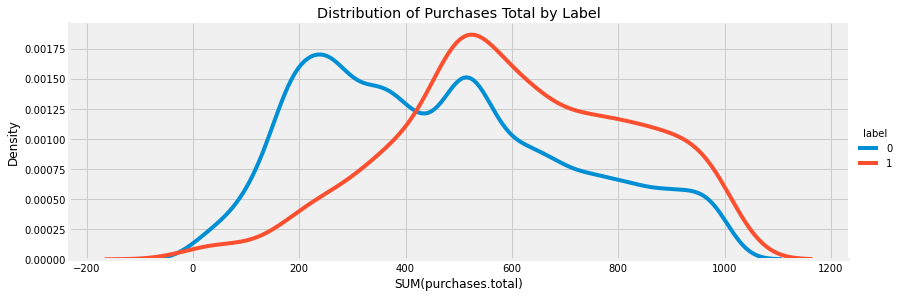

In [48]:
g = sns.FacetGrid(feature_matrix[(feature_matrix['SUM(purchases.total)'] > 0) & (feature_matrix['SUM(purchases.total)'] < 1000)],
                  hue = 'label', size = 4, aspect = 3)
g.map(sns.kdeplot, 'SUM(purchases.total)')
g.add_legend();
plt.title('Distribution of Purchases Total by Label');

The sum of purchase totals prior to the month of the label is clearly higher for those customers who then went on to spend more than \$500 in the next month. We would expect this to be a useful feature in modeling. 

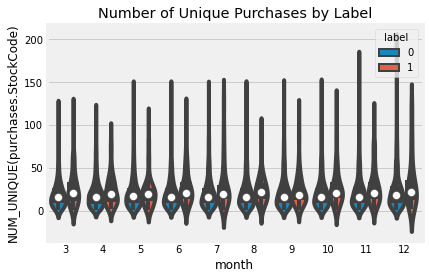

In [49]:
feature_matrix['month'] = feature_matrix['time'].dt.month
sns.violinplot(x = 'month', y = 'NUM_UNIQUE(purchases.StockCode)', hue = 'label', figsize = (24, 6),
               data = feature_matrix[(feature_matrix['SUM(purchases.total)'] > 0) & (feature_matrix['SUM(purchases.total)'] < 1000)])
plt.title('Number of Unique Purchases by Label');

## Preliminary modeling

We can now directly use this feature matrix for training and making predictions with a machine learning model. We'll predict one month at a time, each time training on all the previous observations. The testing features for each testing label are built using all data prior to the month of the testing label.

### Model

For a model, we will use the `RandomForestClassifier` as implemented in Scikit-Learn. We'll keep most of the hyperparameters at the default values but increase the number of trees to 1000. This is not an optimized model but should allow us to tell whether or not our solution is better than a baseline estimate.

In [50]:
model = RandomForestClassifier(n_estimators = 1000, 
                               random_state = 50,
                               n_jobs = -1)

In [51]:
from sklearn.pipeline import Pipeline

The function below trains and tests for a single month. We pass in the month, and the training data is subsetted to label - observation pairs from before the month, while the testing data comes from the month. This ensures that when making predictions for one month, we're only using data from before than month.

In [52]:
def predict_month(month, feature_matrix, return_probs = False):
    """Train and test a machine learning model using a feature set 
    for one month. Testing labels are from the month."""

    feature_matrix['month'] = feature_matrix['time'].dt.month
    
    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['month'] == month, 'label']
    train_labels = feature_matrix.loc[feature_matrix['month'] < month, 'label']
    
    # Features
    X_train = feature_matrix[feature_matrix['time'].dt.month < month].drop(columns = ['CustomerID', 'time',
                                                                                     'month', 'label', 'total'])
    X_test = feature_matrix[feature_matrix['time'].dt.month == month].drop(columns = ['CustomerID', 'time',
                                                                                     'month', 'label', 'total'])
    feature_names = list(X_train.columns)
    
    # Impute and scale features
    pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

    # Fit and transform training data
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))
    
    # Train 
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    p = precision_score(y_test, predictions)
    r = recall_score(y_test, predictions)
    f = f1_score(y_test, predictions)
    auc = roc_auc_score(y_test, probs)
    
    print(f'Precision: {round(p, 5)}')
    print(f'Recall: {round(r, 5)}')
    print(f'F1 Score: {round(f, 5)}')
    print(f'ROC AUC: {round(auc, 5)}')
    
    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    if return_probs:
        return fi, probs
    
    return fi
    

In [53]:
june_fi = predict_month(6, feature_matrix)

Training on 5266 observations.
Testing on 2489 observations.

Precision: 0.55519
Recall: 0.40141
F1 Score: 0.46594
ROC AUC: 0.7488


We can plot the feature importances using a utility function. These should allow us to see what the model considers useful information for predicting spending.

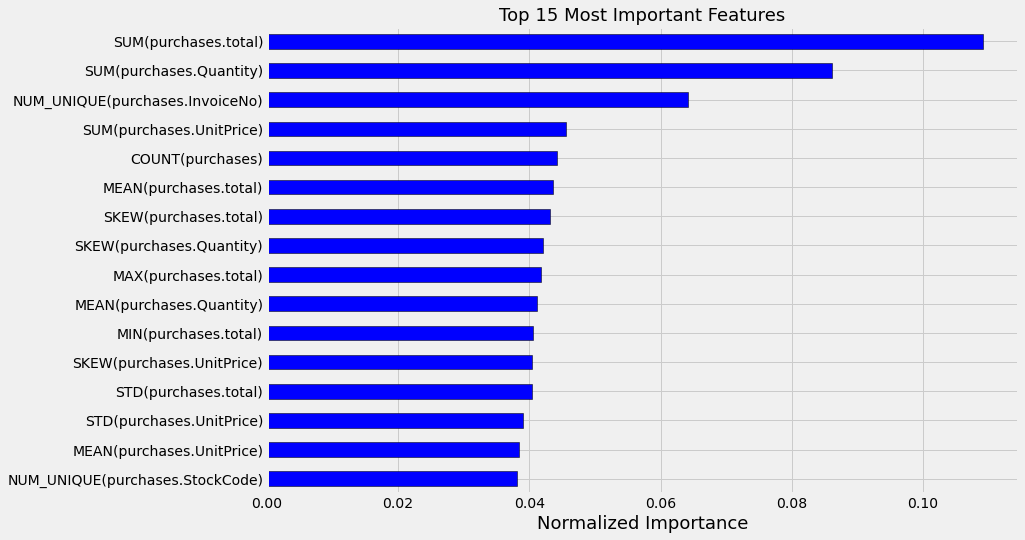

In [54]:
from utils import plot_feature_importances

norm_june_fi = plot_feature_importances(june_fi)

- The most important features are those that are most correlated with the total. 
- This should give us confidence that our machine learning model is learning the important relationships and that the Featuretools features are useful for the problem.
- If we want to predict future spending next month, the best indicators are the customer's total spending to date and the total number of their purchases to date.

# Comparison to Baseline

We calculated metrics for our model, but it's possible that these numbers are no better than we might have done by guessing. One question we have to ask is how do those numbers compare to an informed baseline? If our model can't beat a simple baseline, then we might want to question our approach or even if machine learning is applicable to the problem. 

For an informed baseline, let's use the amount the customer spent in the past month to predict how much they will spend in the next month. We can try this for July 2011. For the probability (used for the ROC AUC), we'll divide the previous month's total by the threhold (so a spending of 0 corresponds to 0 probability) and then clip any values to 1.

In [55]:
labels.head()

,CustomerID,time,total,label
0,13313.0,2011-03-01,0.000,0
1,18097.0,2011-03-01,0.000,0
2,16656.0,2011-03-01,589.248,1
3,16875.0,2011-03-01,0.000,0
4,13094.0,2011-03-01,115.434,0


In [56]:
labels['month'] = labels['time'].dt.month
july_labels = labels[labels['month'] == 7]
june_labels = labels[labels['month'] == 6]

july_labels = july_labels.rename(columns = {'total': 'july_total'})
june_labels = june_labels.rename(columns = {'total': 'june_total'})

# Merge the current month with the previous
july_labels = july_labels.merge(june_labels[['CustomerID', 'june_total']], on = 'CustomerID', how = 'left')
july_labels['june_total'] = july_labels['june_total'].fillna(0)
july_labels['predicted_label'] = (july_labels['june_total'] > 500).astype(int)

july_labels['probability'] = july_labels['june_total'] / 500
    
# Set probabilities greater than 1 equal to 1
july_labels.loc[july_labels['probability'] > 1, 'probability'] = 1
    
july_labels.sample(10, random_state=50)

,CustomerID,time,july_total,label,month,june_total,predicted_label,probability
1647,14711.0,2011-07-01,0.0000,0,7,778.8165,1,1.00000
627,14849.0,2011-07-01,1342.9185,1,7,1624.8210,1,1.00000
2434,13213.0,2011-07-01,0.0000,0,7,221.2650,0,0.44253
2236,15258.0,2011-07-01,0.0000,0,7,507.3750,1,1.00000
1852,14747.0,2011-07-01,0.0000,0,7,0.0000,0,0.00000
1547,13946.0,2011-07-01,0.0000,0,7,0.0000,0,0.00000
241,13004.0,2011-07-01,508.9260,1,7,1121.6040,1,1.00000
437,13982.0,2011-07-01,0.0000,0,7,520.8060,1,1.00000
2043,14323.0,2011-07-01,0.0000,0,7,-29.2050,0,-0.05841
1972,17827.0,2011-07-01,0.0000,0,7,0.0000,0,0.00000


To test whether this is reasonable, we can find the correlation between the previous months total and the current months total.

In [57]:
july_labels['july_total'].corr(july_labels['june_total'])

0.6212795006643782

There is a moderate correlation between spending from one month to the next.

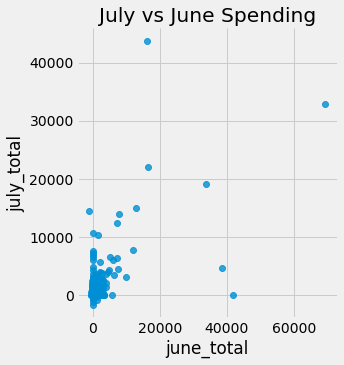

In [58]:
sns.lmplot('june_total', 'july_total', data = july_labels, fit_reg = False)
plt.title('July vs June Spending');

Let's look at the four performance metrics.

In [59]:
print('Precision: {:.5f}.'.format(precision_score(july_labels['label'], july_labels['predicted_label'])))
print('Recall: {:.5f}.'.format(recall_score(july_labels['label'], july_labels['predicted_label'])))
print('F1 Score: {:.5f}.'.format(f1_score(july_labels['label'], july_labels['predicted_label'])))
print('ROC AUC Score: {:.5f}.'.format(roc_auc_score(july_labels['label'], july_labels['probability'])))

Precision: 0.41784.
Recall: 0.39644.
F1 Score: 0.40686.
ROC AUC Score: 0.64355.


We can now compare this performance to that from the model. 

In [60]:
july_fi, july_probs = predict_month(7, feature_matrix, True)

Training on 7755 observations.
Testing on 2752 observations.

Precision: 0.53191
Recall: 0.33408
F1 Score: 0.4104
ROC AUC: 0.75889


For a classifier, the most important metric is the ROC AUC because that accounts for performance across all possible thresholds. We can adjust the threshold to maximize the Recall/Precision/F1 Score depending on our preferences.

To make sure that our model is really outperforming the baseline, we can plot the Receiver Operating Characteristic Curve for the two sets of predictions.

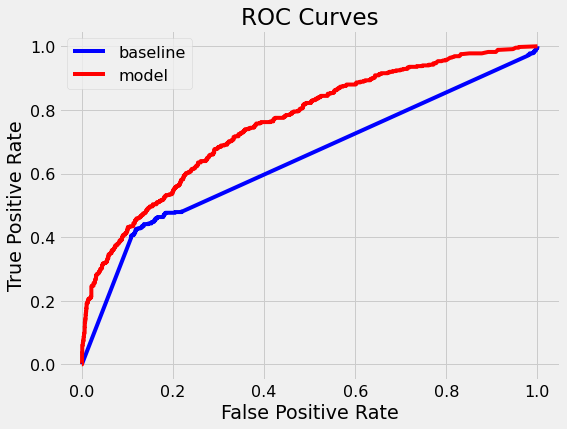

In [61]:
# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(july_labels['label'], july_labels['probability'])
model_fpr, model_tpr, _ = roc_curve(feature_matrix[feature_matrix['month'] == 7]['label'], july_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

__Based on the metrics and this plot, we can say that our model does indeed outperform the informed baseline guess.__ Machine learning, and the features from Featuretools, yield us a better solution than using a decent approximation.

__If we were an online retailer currently using an informed guess for advertising, machine learning could make our advertising campaigns more efficient.__

Let's take all of the code for comparing the baseline to the model and put it in a single function. First we need to calculate the informed baseline in a function. 

In [62]:
def informed_baseline(month_number, threshold = 500):
    """Calculate an informed baseline for a given month. 
    The informed baseline is guessing the previous month's spending
    for the next month. The probability is assessed by dividing
    the previous month's total by the threshold and setting
    any values greater than 1 to 1."""
    
    # Subset to the months
    month = labels[labels['month'] == month_number]
    previous_month = labels[labels['month'] == (month_number - 1)]
    previous_month = previous_month.rename(columns = {'total': 'previous_total'})

    # Merge the current month with the previous month
    month = month.merge(previous_month[['CustomerID', 'previous_total']], on = 'CustomerID', how = 'left')
    
    # For customers who had no spending in the previous month, set their spending to 0
    month['previous_total'] = month['previous_total'].fillna(0)
    
    # Calculate a probability based on the previous months spending and the threshold
    month['probability'] = month['previous_total'] / threshold
    
    # Set probabilities greater than 1 equal to 1
    month.loc[month['probability'] > 1, 'probability'] = 1
    
    # Make the predicted label
    month['prediction'] = (month['previous_total'] > threshold).astype(int)
    
    # Calculate metrics
    print('Precision: {:.5f}.'.format(precision_score(month['label'], month['prediction'])))
    print('Recall: {:.5f}.'.format(recall_score(month['label'], month['prediction'])))
    print('F1 Score: {:.5f}.'.format(f1_score(month['label'], month['prediction'])))
    print('ROC AUC Score: {:.5f}.'.format(roc_auc_score(month['label'], month['probability'])))
    
    return month

The next function compares a machine learning model trained on a set of features to the informed baseline.

In [63]:
def compare(month, feature_matrix):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    print('Baseline Performance')
    baseline = informed_baseline(month)
    
    print('\nModel Performance')
    fi, probs = predict_month(month, feature_matrix, return_probs=True)
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(baseline['label'], baseline['probability'])
    model_fpr, model_tpr, _ = roc_curve(feature_matrix[feature_matrix['month'] == month]['label'], probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    

Baseline Performance
Precision: 0.41201.
Recall: 0.46714.
F1 Score: 0.43784.
ROC AUC Score: 0.67322.

Model Performance
Training on 5266 observations.
Testing on 2489 observations.

Precision: 0.55519
Recall: 0.40141
F1 Score: 0.46594
ROC AUC: 0.7488


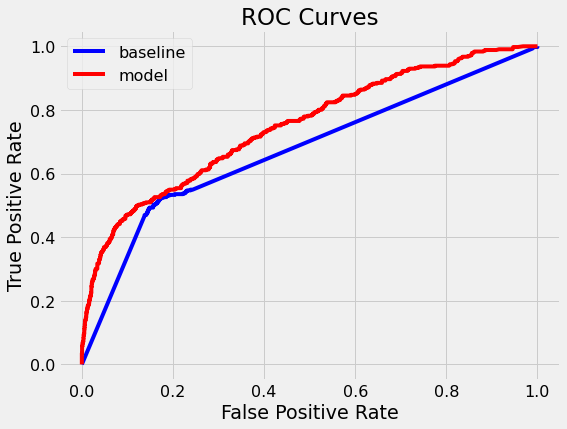

In [64]:
compare(6, feature_matrix)

- We clearly see our model outperforming the baseline. In practice, we would optimize the model threshold for Precision/Recall/F1 Score.

Let's test December, when theoretically our model should do the best because it is training on the most data.

Baseline Performance
Precision: 0.21606.
Recall: 0.57547.
F1 Score: 0.31416.
ROC AUC Score: 0.69498.

Model Performance
Training on 23936 observations.
Testing on 4197 observations.

Precision: 0.30977
Recall: 0.46855
F1 Score: 0.37297
ROC AUC: 0.79344


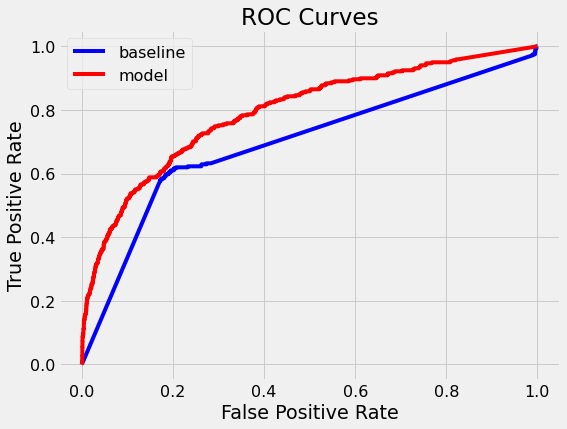

In [65]:
compare(12, feature_matrix)

We get a slightly better ROC AUC. It's possible that the data does not stay consistent over the couse of the year so using more data might not necessarily create a better model. In other words, consumer behavior can shift (potentially due to seasonality) so the older data might not be relevant.

Feel free to check all of the months! It's clear that featuretools and machine learning is able to outperform the baseline for this problem. Even without concentrating on the model, we were able to perform significantly better than a well-informed guess. With some minor hyperparameter tuning (using random search) we could achieve even better performance. We'll not implement any hyperparameter tuning here, but usually it delivers a small performance gain relative to feature engineering (as can be seen in the other two projects in this repository.)

## Precision Recall Curve

Our model was using a default threshold of 0.5 to make predictions. We can use the precision recall curve to identify the ideal threshold for our model. For example, we may care more about identifying customers who will spend more than \$500 than about false positive so we choose a threshold that results in high recall but low precision. Conversely, we may want to limit false positives even if that means missing some potential high-spending customers so we would try for a higher level of precision. The ideal threshold for a classifier will depend on the problem.

We use the ROC AUC to compare models across a range of thresholds, so we know which model is strictly better, but then we can use a precision recall curve to adjust the threshold for our business needs. This is usually a process done with the help of domain experts and validated in cross validation (or on a separate validation set of data). 

In [66]:
def precision_recall(month, feature_matrix):
    "Show the precision vs recall curve for a month"
    
    # Find the probability
    fi, probs = predict_month(month, feature_matrix, 
                              return_probs = True)
    
    # Calculate metrics across thresholds
    precision, recall, t = precision_recall_curve(labels.loc[labels['time'].dt.month == month, 'label'], 
                                                  probs)
    
    # Plot the curve
    plt.step(recall, precision, color='b', alpha=0.5,
             where='post')
    
    # Fill in the curve
    plt.fill_between(recall, precision, step='post', alpha=0.5,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision vs. Recall Curve"); plt.show();

Training on 23936 observations.
Testing on 4197 observations.

Precision: 0.30977
Recall: 0.46855
F1 Score: 0.37297
ROC AUC: 0.79344


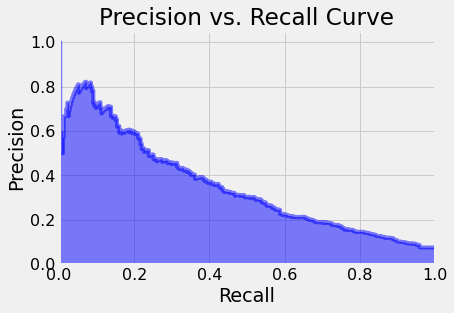

In [67]:
precision_recall(12, feature_matrix)

Training on 16631 observations.
Testing on 3467 observations.

Precision: 0.50833
Recall: 0.29048
F1 Score: 0.3697
ROC AUC: 0.72216


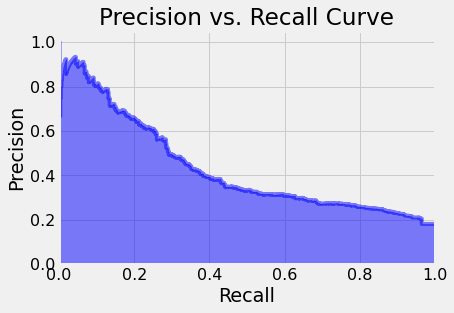

In [68]:
precision_recall(10, feature_matrix)

Depending on what we want to maximize for, we can use these plots to select the appropriate threshold. If we want a recall around 80%, then we would have to accept a precision of near 25%.

Below we generate probabilities for each month to plot the ROC curve compared to both the baseline and manual engineered features. The graphs can be seen in the conclusions section. The code used to make the graphs is included in the Manual Retail Spending notebook.

In [69]:
%%capture

# Record probabilities for each month
for month in range(4, 13):
    _, probs = predict_month(month, feature_matrix, return_probs = True)
    
    temp_df = pd.DataFrame({'Automated': probs, 'month': month})
    
    if month == 4:
        probs_df = temp_df.copy()
    
    else:
        probs_df = probs_df.append(temp_df)


In [70]:
probs_df.head()

,Automated,month
0,0.029,4
1,0.104,4
2,0.943,4
3,0.184,4
4,0.297,4


In [71]:
probs_df.shape

(26851, 2)

In [72]:
probs_df['month'].unique()

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12])

# Conclusions

In this notebook we saw that Featuretools automated feature engineering in a machine learning pipeline results in better prediction of future customer behavior than an informed baseline guess. There are many advantages to using Featuretools in a time-series problem with multiple tables of data such as we often encounter in real life. Following are the key takeaways:

1. Featuretools creates a rich set of relevant features from a set of related tables
    * These features can deliver effective machine learning model performance
2. Featuretools handles the issue of filtering data in a time-series problem
    * Cutoff times for each label filter data 
    * All features for each label use only valid data
3. Even using the default settings for Featuretools, we can create an effective machine learning model
    * The featuretools and random forest classifier outperformed an informed guess in terms of ROC AUC and F1 score

One can try doing manual feature engineering for this problem, but the time spent will be significantly more than with Featuretools and yet there is a rare possibility to develop a model better than the baseline. 

Data science is about using the right methods to get the job done as efficiently as possible, and for the retail dataset, that method is Featuretools in a predictive modeling pipeline. The implementation with automated feature engineering is faster, safer, and just as interpretable as any manual engineering work and delivers an effect machine learning model.